In [36]:
import pandas as pd

target_file_path = "/content/drive/MyDrive/machine_learning_challenge/ML-challenge/EX_challenging_problems/01_guessing_titanic_survivors/titanic.csv"
features = pd.read_csv(target_file_path, index_col = 0)

# Preprocessing for missing values

processed_csv  = features

processed_csv["Age"] = features["Age"].fillna(features["Age"].mean())
processed_csv["Sex"] = features["Sex"].map({'male' : 0, 'female' : 1})
processed_csv.drop(["Ticket", "Embarked", "Cabin"], axis = 1, inplace = True)

# name to score?
# arbitrarily scored according to the appellation, assisted by Google Bard AI.
appellation_score = {
    "Lady": 240,
    "theCountess": 200,
    "Mme": 180,
    "Ms": 170,
    "Mrs": 165,
    "Miss": 130,
    "Don": 80,
    "Rev": 65,
    "Dr": 60,
    "Major": 55,
    "Sir": 50,
    "Col": 45,
    "Mr" : 45,
    "Capt": 40,
    "Master": 35,
    "Mlle": 30,
    "Jonkheer": 25
}

def name_to_priority_assumption(name):
  appellation = name.split(",")[1].split(".")[0].replace(" ", "")
  return appellation_score[appellation]

# Redefine
processed_csv["Name"] = processed_csv["Name"].apply(lambda x : name_to_priority_assumption(x))

####
# I JUST ARBITRARILY DECIDED NOT TO USE "CABIN" FEATURE IN THIS EXPERIMENT!
####

print(processed_csv)

             Survived  Pclass  Name  Sex        Age  SibSp  Parch     Fare
PassengerId                                                               
1                   0       3    45    0  22.000000      1      0   7.2500
2                   1       1   165    1  38.000000      1      0  71.2833
3                   1       3   130    1  26.000000      0      0   7.9250
4                   1       1   165    1  35.000000      1      0  53.1000
5                   0       3    45    0  35.000000      0      0   8.0500
...               ...     ...   ...  ...        ...    ...    ...      ...
887                 0       2    65    0  27.000000      0      0  13.0000
888                 1       1   130    1  19.000000      0      0  30.0000
889                 0       3   130    1  29.699118      1      2  23.4500
890                 1       1    45    0  26.000000      0      0  30.0000
891                 0       3    45    0  32.000000      0      0   7.7500

[891 rows x 8 columns]


In [41]:
# ready for data

passenger_data_input  = processed_csv[["Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Fare"]].to_numpy()
passenger_data_target = processed_csv[["Survived"]].to_numpy()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

def run_experiment(max_depth):
  train_input, test_input, train_target, test_target = train_test_split(passenger_data_input, passenger_data_target)

  # standardization preprocessing (from sklearn.preprocessing import StandardScaler)

  ss = StandardScaler()
  ss.fit(train_input)

  train_scaled = ss.transform(train_input)
  test_scaled  = ss.transform(test_input)

  decisionTree = DecisionTreeClassifier(max_depth = max_depth, random_state=10)
  decisionTree.fit(train_scaled, train_target)               

  return decisionTree.score(test_scaled, test_target)

max accuracy: 0.8225336322869952 when 3


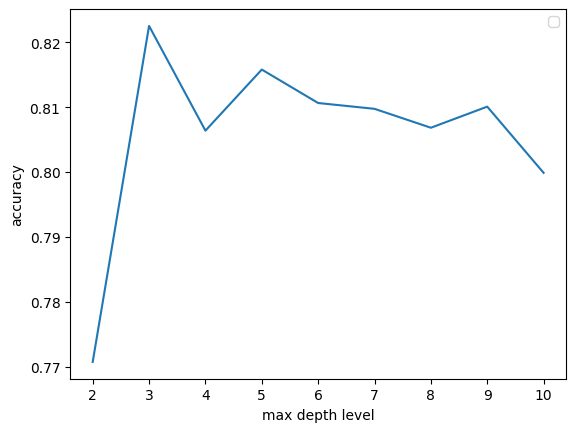

In [42]:
# Which max_depth is the most ideal?

import matplotlib.pyplot as plt

average_accuracy_list = []
trial_per_depth_level = 40

for _max_depth_trial in range(2, 10 + 1):
  temp = 0
  for _trial in range(trial_per_depth_level):
    temp += run_experiment(_max_depth_trial)
  average_accuracy_list.append(temp / trial_per_depth_level)

print(f"max accuracy: {max(average_accuracy_list)} when {average_accuracy_list.index(max(average_accuracy_list)) + 2}")

plt.plot(range(2, 10 + 1), average_accuracy_list)
plt.ylabel("accuracy")
plt.xlabel("max depth level")
plt.legend()
plt.show()

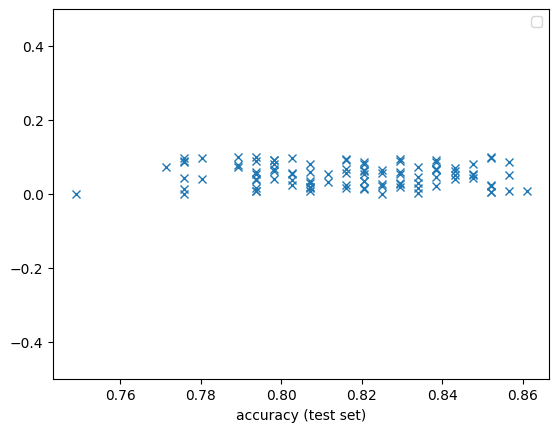

max accuracy : 0.8609865470852018
min accuracy : 0.7488789237668162
avg accuracy : 0.8169058295964123


In [46]:
# get an average accuracy for multiple experiments
import numpy as np
import random

accuracy_list = []

trial = 100
for _seq in range(trial):
  accuracy_list.append(run_experiment(max_depth = 4))

y_dummy_list = [random.random()/10 for _rand in range(trial)]
ax = plt.gca()
ax.set_ylim([-0.5, 0.5])
plt.plot(accuracy_list, y_dummy_list, 'x')
plt.xlabel("accuracy (test set)")
plt.legend()
plt.show()      # we don't need to take care about Matplotlib artist warning. Just ignore.

# print(accuracy_list)
# plt.plot(accuracy_list, np.zeros_like(accuracy_list))
print(f"max accuracy : {max(accuracy_list)}")
print(f"min accuracy : {min(accuracy_list)}")
print(f"avg accuracy : {sum(accuracy_list) / len(accuracy_list)}")

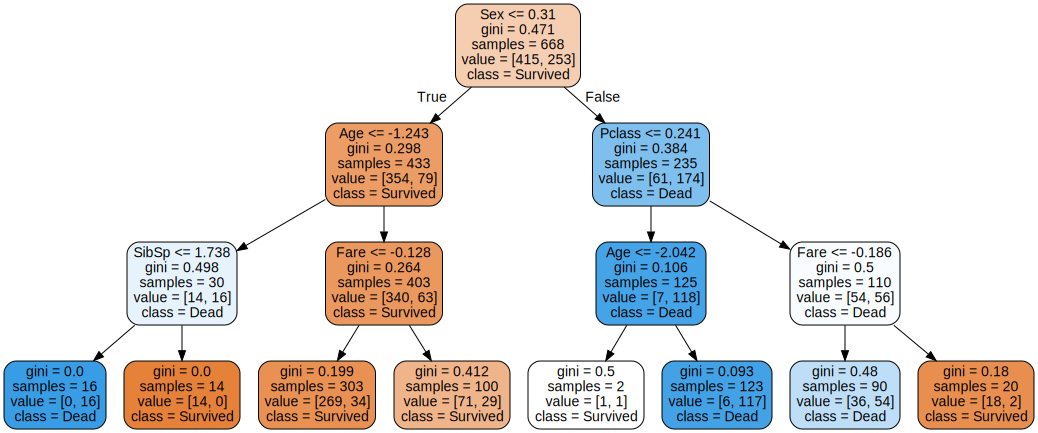

In [47]:
# Wanna see a tree in a graphical form?

train_input, test_input, train_target, test_target = train_test_split(passenger_data_input, passenger_data_target)
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled  = ss.transform(test_input)
decisionTree = DecisionTreeClassifier(max_depth = 3, random_state=10)
decisionTree.fit(train_scaled, train_target)    

# Export the current tree model as a graphical form, then save
from sklearn.tree import export_graphviz
tree_pic_filename = "titanic_decision_tree_graphical_visualization_example.dot"
export_graphviz(
        decisionTree,
        out_file      = tree_pic_filename,
        feature_names = ["Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Fare"],
        class_names   = ['Survived', 'Dead'],
        rounded=True,
        filled=True
    )

# Load the graphviz file from the disk and render on the screen to see what it is directly
import graphviz
with open(tree_pic_filename) as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='titanic_tree', directory='images/decision_trees', cleanup=True)
dot